In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Add, Activation, Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Reshape

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
tf.Tensor(228.28229, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-12 14:00:59.384034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 14:00:59.856582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [4]:
data = np.load('./generated_data/simulated_data_010124_5K.npy')

In [5]:
os.environ['PYTHONHASHSEED']=str(123)

np.random.seed(123)
tf.random.set_seed(123)

In [6]:
# Split the data
initial_state = data[:, 0]
final_state = data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

In [7]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.15, random_state=123)

# further splitting it in training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=123)

In [8]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3612, 32, 32, 32, 1),
 (3612, 32, 32, 32, 1),
 (638, 32, 32, 32, 1),
 (638, 32, 32, 32, 1),
 (750, 32, 32, 32, 1),
 (750, 32, 32, 32, 1))

In [9]:
# Parameters
Ngrid = 32  # grid size

In [10]:
# Configuring the input shape
input_shape = Input(shape=(Ngrid, Ngrid, Ngrid, 1))

In [11]:
# Building the model
x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(input_shape)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='linear', padding='same')(x)  # use a linear activation function for regression

ae_model = Model(input_shape, decoded)

In [12]:
# Compile the model
ae_model.compile(optimizer=Adam(), 
                   loss='mse',
                   metrics=['mae'],
                   run_eagerly=True)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.001)
checkpoint = ModelCheckpoint('resnet_5K.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)

In [14]:
history = ae_model.fit(x=X_train, 
                         y=y_train, 
                         validation_data=(X_val, y_val), 
                         batch_size=32, 
                         epochs=50, 
                         callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/50


2024-01-12 14:01:03.544087: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


113/113 [==============================] - ETA: 0s - loss: 1.3177 - mae: 0.7263
Epoch 1: val_loss improved from inf to 0.82339, saving model to resnet_5K.hdf5
113/113 [==============================] - 8s 46ms/step - loss: 1.3177 - mae: 0.7263 - val_loss: 0.8234 - val_mae: 0.6232 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.7698 - mae: 0.6146
Epoch 2: val_loss improved from 0.82339 to 0.73186, saving model to resnet_5K.hdf5
113/113 [==============================] - 4s 38ms/step - loss: 0.7698 - mae: 0.6146 - val_loss: 0.7319 - val_mae: 0.5976 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 0.7187 - mae: 0.5950
Epoch 3: val_loss improved from 0.73186 to 0.70553, saving model to resnet_5K.hdf5
113/113 [==============================] - 4s 38ms/step - loss: 0.7187 - mae: 0.5950 - val_loss: 0.7055 - val_mae: 0.5879 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - ETA: 0s - loss: 0.6988 - mae: 0.58

In [15]:
eval_results = ae_model.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

24/24 [==============================] - 1s 21ms/step - loss: 0.5706 - mae: 0.5473
Evaluation Results:[0.5706343054771423, 0.5472602844238281]


In [16]:
predictions = ae_model.predict(X_test)
predictions.shape

(750, 32, 32, 32, 1)

In [17]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-5.002735977640595, 10.414035)

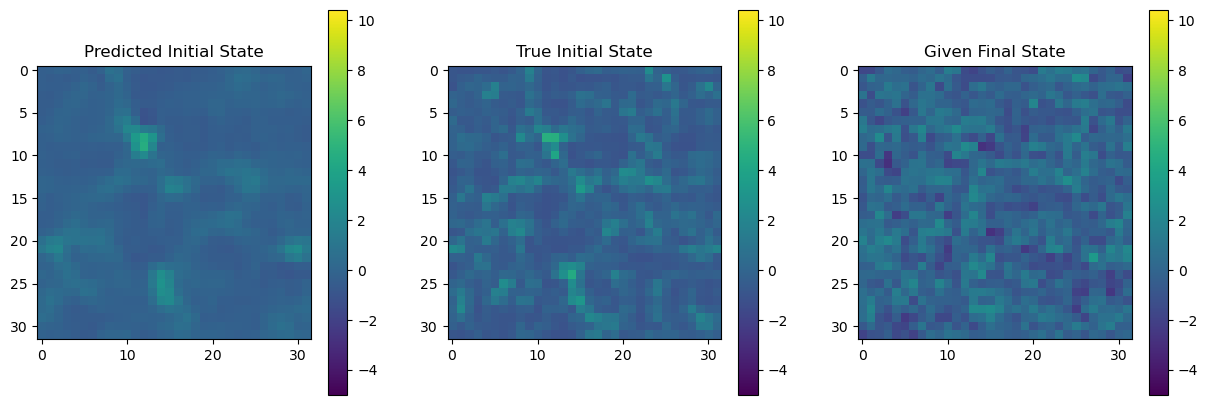

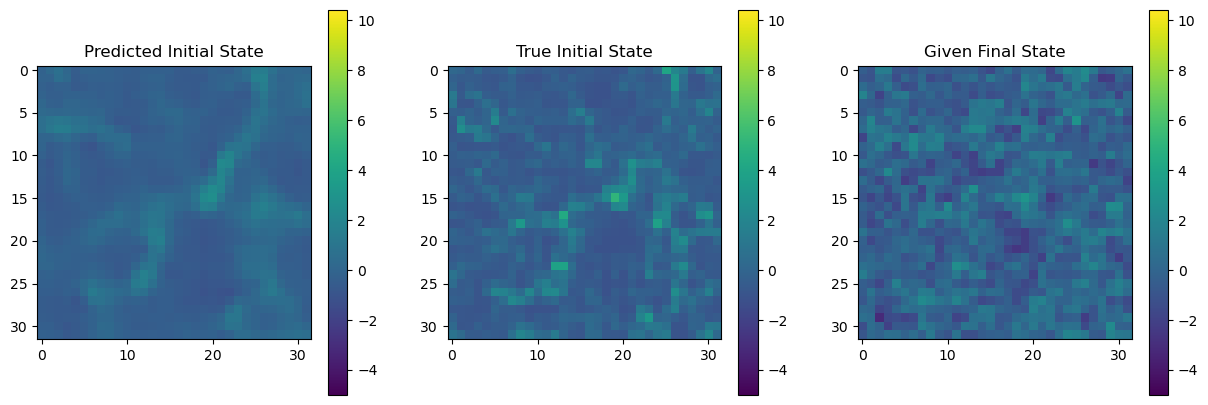

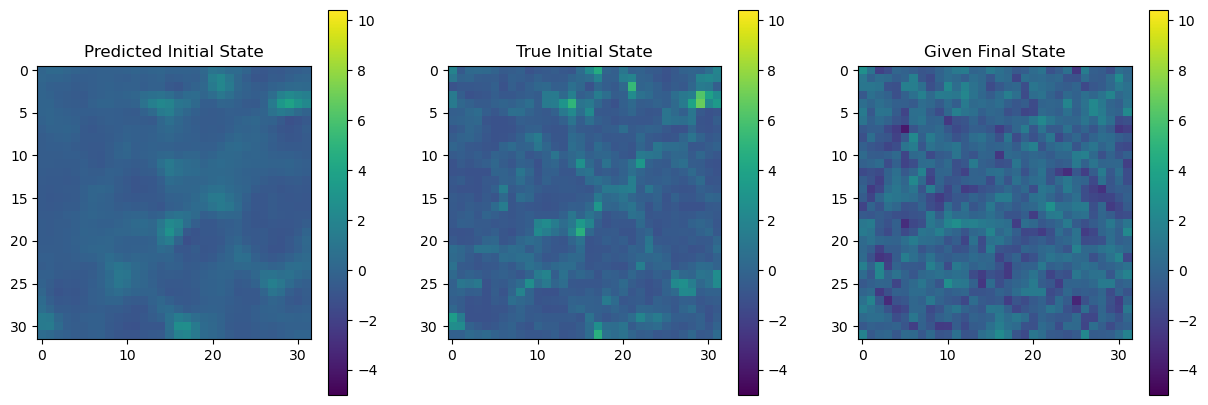

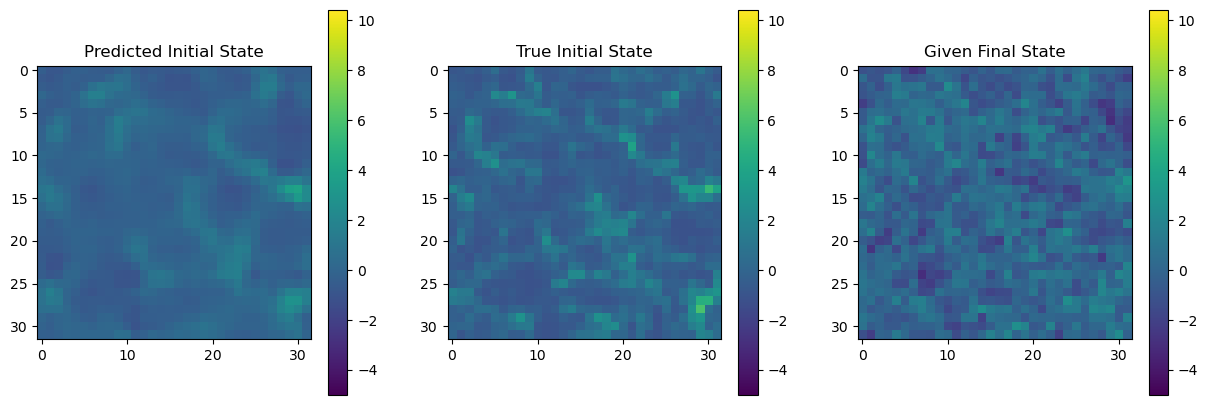

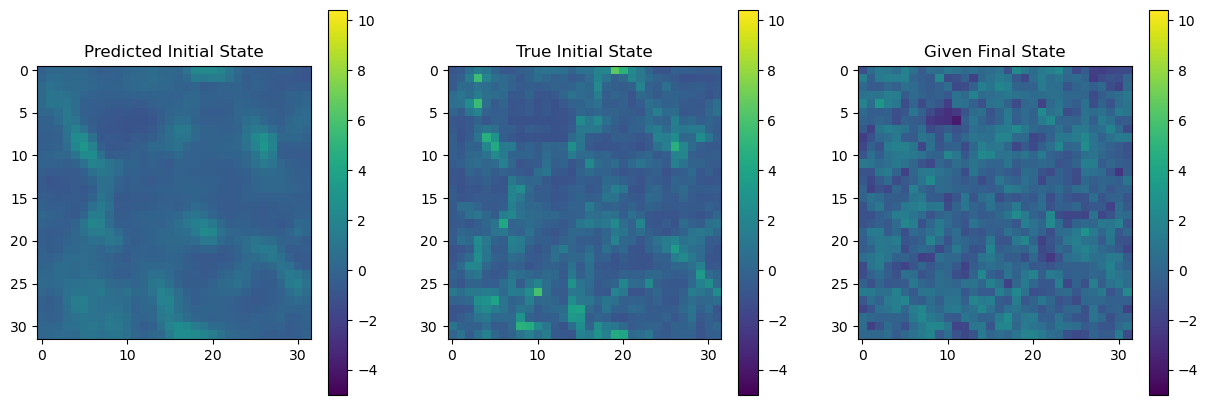

In [18]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax, 
                       cmap='viridis')
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [19]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.5706342879868925
Mean Absolute Error (MAE): 0.5472603260460221


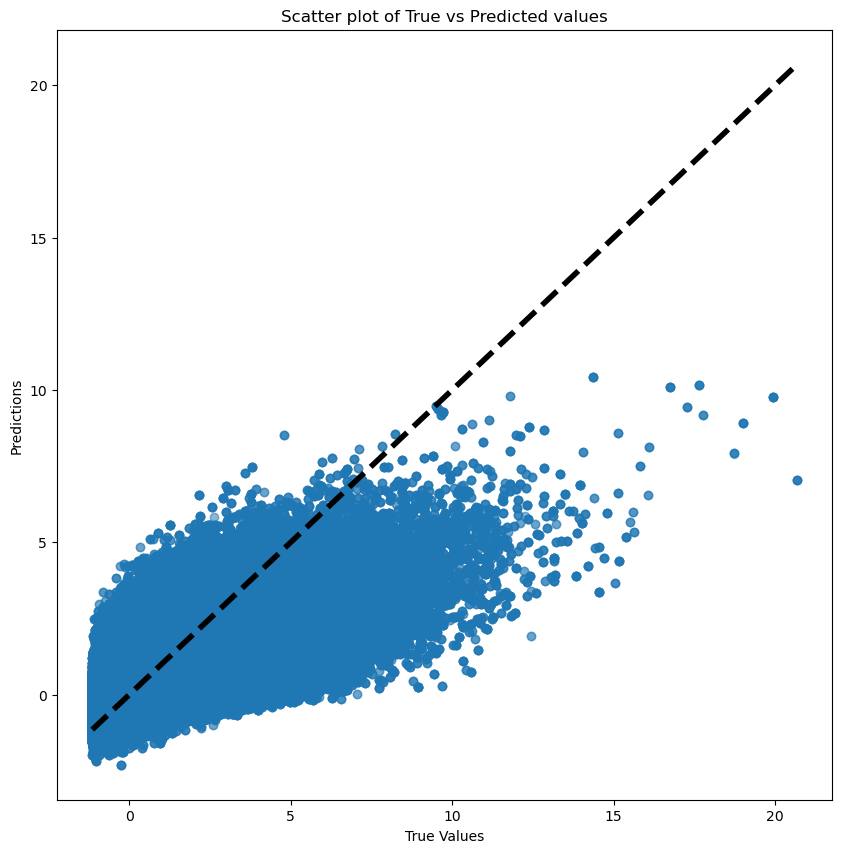

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()